In [65]:
def image_crop(file, image_width, image_height, cropped_width, cropped_height):
    cropped_images = []
    x = 0
    x_center = image_width // 2
    y_center = image_height // 2
    
    while x < image_width:
        y = 0
        while y < image_height:
            cropped_image = file[x : x + cropped_width, y : y + cropped_height]
            cropped_images.append(cropped_image)
            y += cropped_height
        x += cropped_width
    
    center_image = file[x_center - cropped_width // 2 : x_center + cropped_width // 2,
                       y_center - cropped_height // 2 : y_center + cropped_height // 2]
    
    cropped_images.append(center_image)
    
    return cropped_images

In [66]:
def data_generator(file, image_width, image_height):
    img_bgr = cv2.imread(file, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_rgb, (image_width, image_height))

    return img

In [67]:
import cv2
import os, glob, numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

img_dir = './binary_cnn_majority/test'
categories = ['ad', 'non_ad']

image_width = 180 # 사이즈 수정
image_height = 180

X = []
y = []
X_original = []
y_original = []
index = []
files = []
filenames = []
n = 0
df = pd.DataFrame(index=['img_num'], columns=['y', 'pred', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'category'])

for i, category in enumerate(categories):
    img_detail = img_dir + '/' + category
    try:
        files.append(glob.glob(img_detail + "/*.jpg"))
        index.append(i)

    except Exception as e :
        print(e)
        print(i,'번째에서 error')

0
1


In [68]:
    
for file, i in zip(files, index):
    for f in file:
        try:
            img = data_generator(f, image_width, image_height)
        
            original_data = np.asarray(img)
            X_original.append(original_data)
            y_original.append(i)

            df.loc[n, 'y'] = i
            n += 1

            cropped_images = image_crop(img, image_width, image_height, image_width // 2, image_height // 2)

            for cropped_image in cropped_images:
                data = np.asarray(cropped_image)

                head, tail = os.path.split(f)
                filenames.append(tail)

                X.append(data)
                y.append(i)
                
        except Exception as e:
            print(i,'번째에서 에러')

X = np.array(X)
y = np.array(y)
X_original = np.array(X_original)
y_original = np.array(y_original)

X = X.astype('float32') / 255

print(len(X), len(y))
print(len(X_original), len(y_original))

"""인자 바꾸기"""

print(df)

3200 3200
640 640
           y pred  X_0  X_1  X_2  X_3  X_4 category
img_num  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN
0          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
1          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
2          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
3          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
...      ...  ...  ...  ...  ...  ...  ...      ...
635        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
636        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
637        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
638        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
639        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN

[641 rows x 8 columns]


In [69]:
print(X)

[[[[1.000 1.000 1.000]
   [0.596 0.478 0.282]
   [0.843 0.761 0.322]
   ...
   [0.471 0.710 0.808]
   [0.486 0.737 0.851]
   [0.482 0.741 0.859]]

  [[1.000 1.000 1.000]
   [0.557 0.439 0.243]
   [0.808 0.722 0.294]
   ...
   [0.467 0.706 0.804]
   [0.482 0.733 0.847]
   [0.478 0.737 0.855]]

  [[1.000 1.000 1.000]
   [0.486 0.369 0.176]
   [0.745 0.655 0.239]
   ...
   [0.459 0.702 0.800]
   [0.478 0.729 0.843]
   [0.475 0.733 0.851]]

  ...

  [[1.000 1.000 1.000]
   [0.192 0.173 0.161]
   [0.200 0.129 0.114]
   ...
   [0.396 0.639 0.298]
   [0.424 0.627 0.306]
   [0.427 0.612 0.302]]

  [[1.000 1.000 1.000]
   [0.169 0.161 0.149]
   [0.145 0.098 0.075]
   ...
   [0.388 0.604 0.278]
   [0.416 0.592 0.286]
   [0.412 0.573 0.278]]

  [[1.000 1.000 1.000]
   [0.161 0.149 0.125]
   [0.141 0.086 0.043]
   ...
   [0.384 0.580 0.263]
   [0.408 0.569 0.271]
   [0.400 0.545 0.255]]]


 [[[0.478 0.749 0.859]
   [0.486 0.769 0.875]
   [0.498 0.792 0.890]
   ...
   [0.435 0.478 0.314]
   [1.000 

In [70]:
print(X_original)

[[[[255 255 255]
   [152 122  72]
   [215 194  82]
   ...
   [111 122  80]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [142 112  62]
   [206 184  75]
   ...
   [111 121  78]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [124  94  45]
   [190 167  61]
   ...
   [112 118  75]
   [255 255 255]
   [255 255 255]]

  ...

  [[255 255 255]
   [184 186  93]
   [ 82  78  28]
   ...
   [100  62  41]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [213 218 103]
   [ 93  90  32]
   ...
   [103  65  43]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [229 236 108]
   [ 99  96  34]
   ...
   [105  66  44]
   [255 255 255]
   [255 255 255]]]


 [[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[221 225 226]
   [123 140 143]
   [135 153 156]
   ...
   [206 215 211]
   [218 226 223]
   [255 255 255]]

  [[218 224 225]
   [114 138 141]
   [127 151 155]
   ...
   [191 203 198]
   [208 217 213]
   [255 255

In [71]:
print(y)

[0 0 0 ... 1 1 1]


In [72]:
print(y_original)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [73]:
def print_scores(X, y, prediction):
    print('confusion matrix 결과')
    print(confusion_matrix(y, prediction, labels=[0, 1])) # 0 : 광고 1: 비광고

    print('precision 개별값')
    print(list(map('{:2.2f}%'.format, precision_score(y, prediction, average=None) * 100))) # precision 개별 값
    print('recall 개별값')
    print(list(map('{:2.2f}%'.format, recall_score(y, prediction, average=None) * 100)))

    
    print('f1 점수')
    print('{:2.2f}%'.format(f1_score(y, prediction, average='macro') * 100))

    print('precision 평균값')
    print('{:2.2f}%'.format(precision_score(y, prediction, average='macro') * 100)) # precision 평균 값
    
    print('recall 평균값')
    print('{:2.2f}%'.format(recall_score(y, prediction, average='macro') * 100))

In [74]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

"""수정 필요한 부분"""


model_evaluate = []
f1 = []
precision = []
recall = []


model = load_model('./binary_cnn_majority/model/size/binary_model_saved180.h5')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) # 소수점 3자리까지

new_prediction = []    
count = []

n = 0

print(prediction)
print(prediction.shape)

[[0.000]
 [0.000]
 [0.000]
 ...
 [1.000]
 [1.000]
 [1.000]]
(3200, 1)


In [75]:
for p in prediction:
    is_ad = 0
    not_ad = 0
    amax = []

    count.append(p)
    
    if(len(count) == 1):
        df.loc[n, 'X_0'] = p
        continue

    elif(len(count) == 2):
        df.loc[n, 'X_1'] = p
        continue
        
    elif(len(count) == 3):
        df.loc[n, 'X_2'] = p
        continue    
        
    elif(len(count) == 4):
        df.loc[n, 'X_3'] = p
        continue
        
    elif len(count) == 5:
        df.loc[n, 'X_4'] = p
        for c in count:
            amax.append(c.round())
            if c.round() == 0:
                is_ad += 1
            elif c.round() == 1:
                not_ad += 1

        if is_ad > not_ad:
            new_prediction.append(0)
    
            df.loc[n, 'pred'] = 0
            n += 1
            
        else:
            new_prediction.append(1)
            
            df.loc[n, 'pred'] = 1
            n += 1

        count = []

#    elif len(count) < 5:
#        continue


print('개별 결과')
print(len(y), len(prediction))
#print_scores(X, y, prediction)
#model_evaluate.append(model.evaluate(X, y)[1] * 100)
#precision.append(precision_score(y, prediction, average='macro') * 100)
#recall.append(recall_score(y, prediction, average='macro') * 100)
#f1.append(f1_score(y, prediction, average='macro') * 100)

print('투표 결과')
print(len(y_original), len(new_prediction))
print_scores(X_original, y_original, new_prediction)
#model_evaluate.append(model.evaluate(X_original, y_original)[1] * 100)
precision.append(precision_score(y_original, new_prediction, average='macro') * 100)
recall.append(recall_score(y_original, new_prediction, average='macro') * 100)
f1.append(f1_score(y_original, new_prediction, average='macro') * 100)

print(df)

개별 결과
3200 3200
투표 결과
640 640
confusion matrix 결과
[[303  17]
 [ 21 299]]
precision 개별값
['93.52%', '94.62%']
recall 개별값
['94.69%', '93.44%']
f1 점수
94.06%
precision 평균값
94.07%
recall 평균값
94.06%
           y pred              X_0              X_1               X_2  \
img_num  NaN  NaN              NaN              NaN               NaN   
0          0    0  [1.0220319e-05]  [2.0461192e-10]  [1.02509986e-07]   
1          0    0  [3.9571984e-05]    [0.012920737]     [0.006757885]   
2          0    0    [0.021122992]   [0.0007201135]      [0.03370565]   
3          0    1      [0.6688939]     [0.14860243]       [0.7898882]   
...      ...  ...              ...              ...               ...   
635        1    1     [0.99996555]     [0.99982643]       [0.9960462]   
636        1    1      [0.9999429]      [0.9998922]       [0.9882545]   
637        1    1       [0.813138]     [0.42849228]      [0.60819924]   
638        1    1     [0.99999195]     [0.99998033]      [0.99135995]   
639  

In [77]:
df.to_csv('./test_prediction_for_each_file_new.csv', sep=',', na_rep='NaN')

In [22]:
#for i, pred in enumerate(prediction):
 #   if pred >= 0.5: print("해당 " + filenames[i] + "  이미지는 비광고 로 추정됩니다.")
  #  else : print("해당 " + filenames[i] + "  이미지는 광고 로 추정됩니다.")

'수정 필요한 부분'

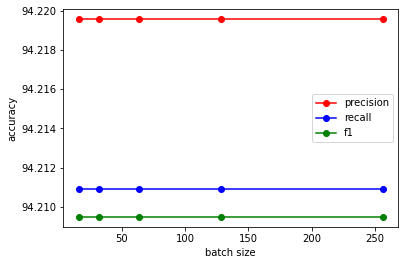

In [6]:
import matplotlib.pyplot as plt


"""수정 필요한 부분"""

plt.plot(batch_list, precision, 'ro-', label='precision') # 리스트 수정
plt.plot(batch_list, recall, 'bo-', label='recall')
plt.plot(batch_list, f1, 'go-', label='f1')
#plt.plot(batch_list, model_evaluate, 'yo-', label='evaluate')
plt.xlabel('batch size') # xlabel 수정
plt.ylabel('accuracy')
plt.legend()

"""수정 필요한 부분"""